<img src='logo.png'><br>
* ref : <a href='https://www.kaggle.com/mlg-ulb/creditcardfraud'>https://www.kaggle.com/mlg-ulb/creditcardfraud</a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
import warnings
warnings.filterwarnings(action='ignore')

sns.set()

In [2]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414
                                                            ,stratify=y) #shuffle=False, 

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            my_eval(y_test, pred, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)                       #점수def호출

## 데이터 로드 

In [3]:
df = pd.read_csv("sample5.csv")

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', dual=False,C=1.0,random_state=1414,
                           max_iter=100, multi_class='auto')

##  1차 점수 확인

In [5]:
df.drop(['Time'], axis=1,  inplace=True)

In [6]:
y = df['Class']
X = df.drop(['Class'], axis=1)    

In [7]:
y.value_counts()

0    56863
1       99
Name: Class, dtype: int64

정확도0.9983 정밀도:0.5238 재현률:0.5500 f1:0.5366
오차행렬
 [[11363    10]
 [    9    11]]


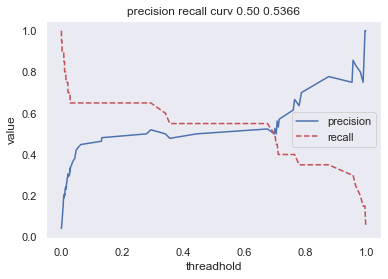

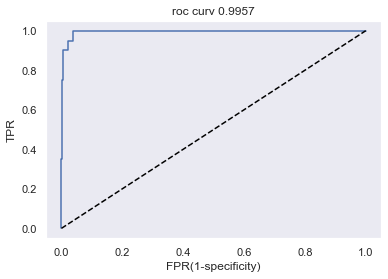

In [8]:
split_fit_score(X, y, model)

## 2차 점수 : 스케일링

In [9]:
df = pd.read_csv("sample5.csv")
# df = pd.read_csv("./creditcard.csv")

df.drop(['Time'], axis=1,  inplace=True)

In [10]:
y = df['Class']
X = df.drop(['Class'], axis=1)

In [12]:
# X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
for sc in scalers:
    sc.fit(X_train['Amount'].values.reshape(-1,1))
    train_sc_arr = sc.transform(X_train['Amount'].values.reshape(-1,1))   #[2 2 2 2 2 2 2 2 2 2 2...]
    test_sc_arr = sc.transform(X_test['Amount'].values.reshape(-1,1))
    X_train['Amount_'+ sc.__class__.__name__[:3]] = train_sc_arr #.reshape(-1,1)
    X_test ['Amount_'+ sc.__class__.__name__[:3]] = test_sc_arr #.reshape(-1,1)    

(45569, 32) (11393, 32) (56962, 32)
(45569,) (11393,) (56962,)
정확도0.9994 정밀도:0.8421 재현률:0.8000 f1:0.8205
오차행렬
 [[11370     3]
 [    4    16]]


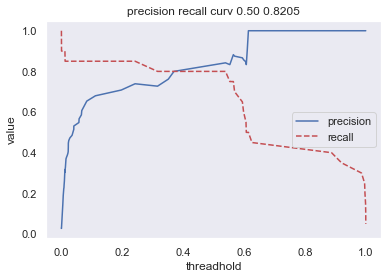

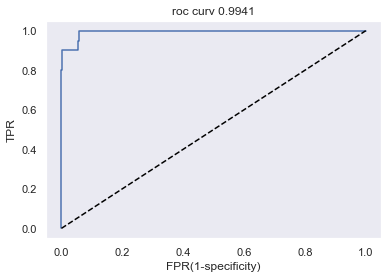

In [13]:
XX = X_train.append(X_test)
yy = y_train.append(y_test)
print(X_train.shape, X_test.shape, XX.shape)
print(y_train.shape, y_test.shape, yy.shape)

XX_std = XX.drop(['Amount','Amount_Min','Amount_Rob'], axis=1)
split_fit_score(XX_std, yy, model)  #------------------------


정확도0.9996 정밀도:0.9091 재현률:0.7143 f1:0.8000
오차행렬
 [[11378     1]
 [    4    10]]


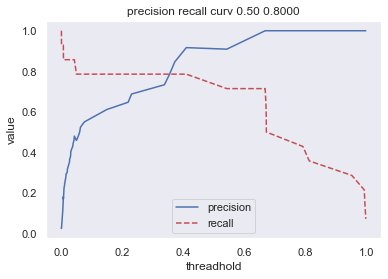

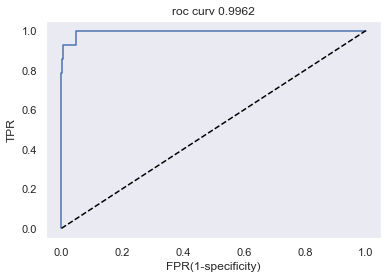

In [14]:

X_train, X_test, y_train, y_test = train_test_split(XX_std, yy, test_size=0.2, shuffle=True)
model.fit(X_train, y_train)
pred = model.predict(X_test)                                        #[0  1]              th:0.5
proba = model.predict_proba(X_test)        
my_eval(y_test, pred, proba, 0.5)   #-------------------------------


## Over sampling : SMOTE

In [15]:
# ! pip install imblearn

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [17]:
print("샘플링전",X_train.shape, y_train.shape)
print(pd.Series(y_train).value_counts())
smote = SMOTE(random_state=1414)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)  #*******test는 절대 오버샘플링하지말것 **************************
print("--"*30)
print("샘플링후",X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

샘플링전 (45569, 29) (45569,)
0    45484
1       85
Name: Class, dtype: int64
------------------------------------------------------------
샘플링후 (90968, 29) (90968,)
0    45484
1    45484
Name: Class, dtype: int64


정확도0.9997 정밀도:0.9231 재현률:0.8571 f1:0.8889
오차행렬
 [[11378     1]
 [    2    12]]


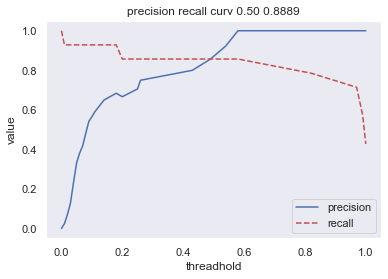

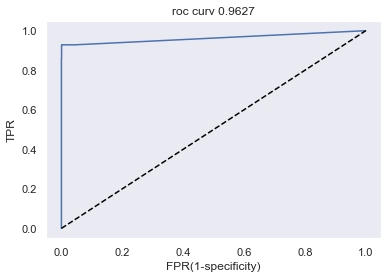

In [23]:
model.fit(X_train_over, y_train_over)
pred = model.predict(X_test)                                        #[0  1]              th:0.5
proba = model.predict_proba(X_test)        
my_eval(y_test, pred, proba, 0.5)   #-------------------------------

## Under sampling  : NearMiss

In [24]:
print("샘플링전",X_train.shape, y_train.shape)
print(pd.Series(y_train).value_counts())
nearmiss = NearMiss()
X_train_under, y_train_under = nearmiss.fit_resample(X_train, y_train)
print("--"*30)
print("샘플링후",X_train_under.shape, y_train_under.shape)
print(pd.Series(y_train_under).value_counts())

샘플링전 (45569, 29) (45569,)
0    45484
1       85
Name: Class, dtype: int64
------------------------------------------------------------
샘플링후 (170, 29) (170,)
0    85
1    85
Name: Class, dtype: int64


정확도0.4612 정밀도:0.0023 재현률:1.0000 f1:0.0045
오차행렬
 [[5240 6139]
 [   0   14]]


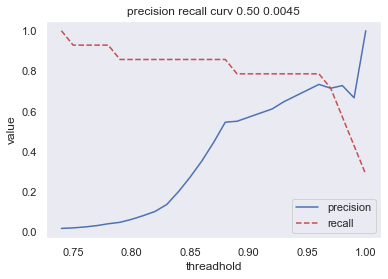

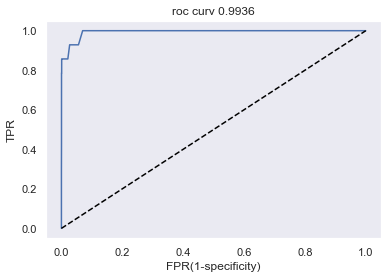

In [26]:
model.fit(X_train_under, y_train_under)
pred = model.predict(X_test)                                        #[0  1]              th:0.5
proba = model.predict_proba(X_test)        
my_eval(y_test, pred, proba, 0.5)   #-------------------------------

## 상관분석

Class 피쳐와 (+) 상관관계 TOP-n Index(['Class', 'V11', 'V4', 'V2', 'V8'], dtype='object')
Class 피쳐와 (-) 상관관계 TOP-n Index(['V17', 'V3', 'V14', 'V12', 'V7'], dtype='object')


<AxesSubplot:>

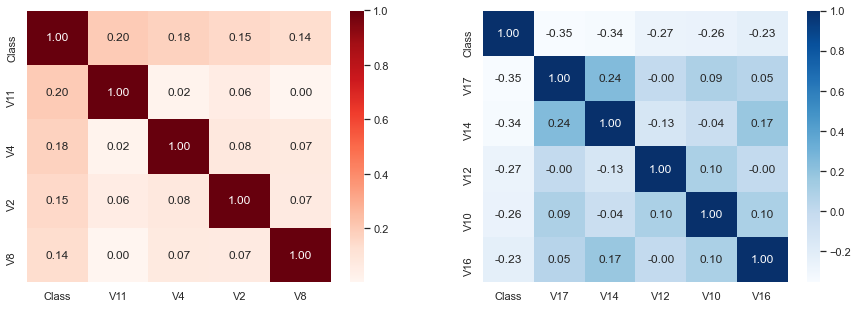

In [19]:
#### Class에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

top_corr_large  = df.corr().nlargest(5, 'Class').index
print("Class 피쳐와 (+) 상관관계 TOP-n", top_corr_large)
sns.heatmap(df[top_corr_large].corr(), annot=True, cmap='Reds', fmt='0.2f' , ax=ax1)

top_corr_small = df.corr().nsmallest(5, 'Class').index
print("Class 피쳐와 (-) 상관관계 TOP-n", top_corr_small)
sns.heatmap(df[['Class','V17', 'V14', 'V12', 'V10', 'V16']].corr(), annot=True, cmap='Blues', fmt='0.2f' , ax=ax2)
# plt.show()

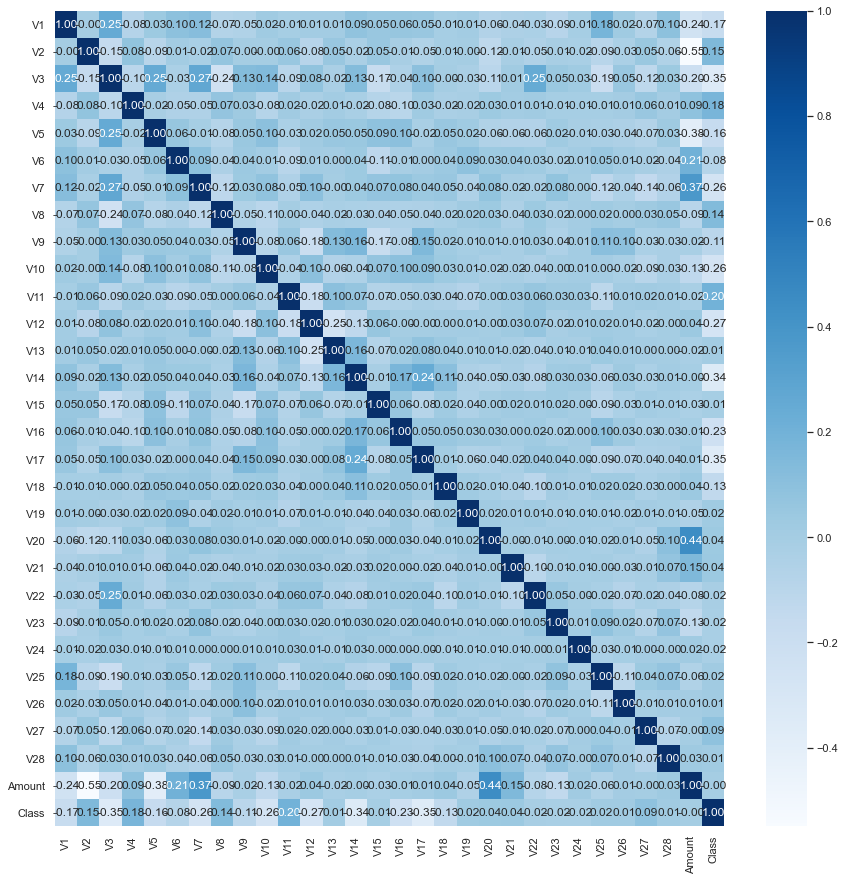

In [20]:
fig, ax = plt.subplots(figsize=(15,15))     
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

### (+) 'V11', 'V4',

### (-) 'V17', 'V14', 'V12'

In [21]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Sta
42428,1.162578,-1.978646,1.374632,-0.739250,-2.567127,0.115023,-1.715138,0.179496,-0.329175,1.035145,...,-0.153286,-0.234944,-0.215561,-0.085160,0.397496,0.276204,-0.127902,0.072663,0.052682,0.182804
29374,-0.882550,1.218500,0.897345,-0.002299,-0.212213,-0.610249,0.315273,0.413183,0.126543,-0.191757,...,0.018251,-0.304349,-0.776412,0.057637,-0.044043,-0.266493,0.087961,0.073990,-0.147598,-0.328982
13093,1.201692,0.379088,0.541918,0.834541,-0.390899,-0.831688,-0.144579,-0.116830,1.133022,-0.467384,...,-0.157257,-0.379815,-0.914505,0.160867,0.418281,0.115815,0.027725,-0.057209,0.015029,-0.360611
32334,1.190686,0.742120,0.813164,2.459147,-0.068382,-0.495705,0.231064,-0.191479,-0.982526,0.624230,...,-0.052488,-0.231827,-0.662305,0.128139,0.383660,0.304256,-0.271471,0.004287,0.031877,-0.364010
36601,1.173761,0.526577,-0.516154,1.120618,0.377313,-0.291043,0.039028,0.132699,-0.141480,-0.519429,...,-0.188599,-0.024458,-0.058609,-0.132027,-0.476028,0.589494,-0.290569,0.039264,0.037880,-0.363662


## 모델 선정 & 학습 & 평가

정확도0.9994 정밀도:0.8824 재현률:0.7500 f1:0.8108
오차행렬
 [[11371     2]
 [    5    15]]


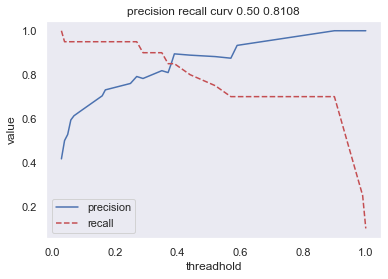

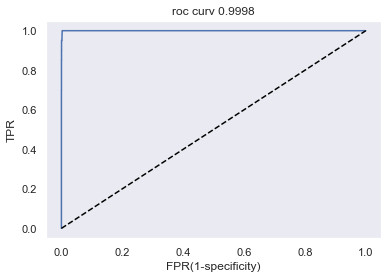

In [22]:
y = df['Class']
X = df.drop('Class', axis=1)
model = RandomForestClassifier(n_estimators=100,random_state=1414) 
split_fit_score(X, y, model=model)